# Notebook containing examples on how to train the model

In [19]:
%reload_ext autoreload
%autoreload 3
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent / 'src'))
from forecastpnn.utils.data_functions import get_dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility
import pandas as pd

from forecastpnn.utils.train_utils import SubsetSampler as SS
from forecastpnn.utils.constants import RANDOM_SEED

WEEKS = True
PAST_UNITS = 12
BATCH_SIZE = 64
RANDOM_SPLIT = False
DEVICE = "mps"

data = pd.read_csv('../data/derived/DENGSP.csv')
dl = get_dataset(data, 'DT_SIN_PRI', weeks_in=False, weeks_out=WEEKS, past_units=PAST_UNITS, return_df=False, filter_year_min=2013, filter_year_max=2020)

#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dl.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dl.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
    else: 
        train_idcs, test_idcs = range(int(0.75*dl.__len__())), range(int(0.75*dl.__len__()), dl.__len__()) # 2844 total obs - 711 test, still 25% even without random split, last outbreak 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(RANDOM_SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dl, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dl, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(RANDOM_SEED)
    global train_loader
    train_loader = DataLoader(dl, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(RANDOM_SEED)

/var/folders/xr/mqd4g8995xqfhcvcyvr2smdc0000gn/T/ipykernel_96871/933801931.py:26: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/derived/DENGSP.csv')
2024-12-15 01:04:17.910 | WARNING  | forecastpnn.utils.data_functions:get_dataset:228 - If output data is indexed by weeks, day of the weeks cannot be used as feature, so keyword dow will be ignored.


reloaded


In [63]:
from forecastpnn.utils.train_utils import train, EarlyStopper
from forecastpnn.models.forecastpnn import ForecastPNN
set_seeds(RANDOM_SEED)

regen_data() # reset samplers so each training run is reproducible
early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, weeks=WEEKS, future_obs=0)
nowcast_pnn = ForecastPNN(past_units=PAST_UNITS)
#nowcast_pnn = PNNSumDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)
train(nowcast_pnn, num_epochs=500, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE)
## Load best set of weights on test/validation set
nowcast_pnn.load_state_dict(torch.load(f".weights/weights-{PAST_UNITS}-{'week' if WEEKS else 'day'}{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if False else ''}"))

tensor([ 1867.,  1664.,  1238., 62633.,  2480.,  2009.,  2010.,  1004.,  5453.,
         2126.,  3667.,  1406.,  1445., 73235.,  1037.,  9927.,  2588., 32946.,
          931.,   964.,  1123.,   611.,   782.,   710.,  1743.,  2166.,  2095.,
         1856., 30177.,  1564., 51051.,  2151.,   826., 30018., 82639.,  1831.,
        23043., 20739.,  1873.,   748.,  2198.,  1861.,  1125.,  1744.,  1381.,
         1168.,  1346.,  2675.,   826.,  2788.,  2182.,  1666.,  2105.,  4436.,
         1880., 63046.,  1155.,  1764.,  2250.,   805.,   970.,  1232.,  5378.,
        18224.], device='mps:0')
tensor([    0.0000,     0.0000,     0.0000, 68636.2031,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,   421.4409,     0.0000,
            0.0000, 82597.5312,     0.0000,  3214.1704,     0.0000, 27834.4023,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000, 30010.4883,     0.0000,
       

KeyboardInterrupt: 

tensor([[29905.],
        [25462.],
        [31871.],
        [32946.],
        [30177.],
        [20739.],
        [15614.],
        [14169.],
        [12008.],
        [ 7858.],
        [ 4843.],
        [ 4449.],
        [ 3693.],
        [ 2839.],
        [ 1925.],
        [ 1604.],
        [ 1400.],
        [ 1131.],
        [  611.],
        [  803.],
        [  853.],
        [  695.],
        [  746.],
        [  680.],
        [  710.],
        [  757.],
        [  854.],
        [  706.],
        [  733.],
        [  775.],
        [  864.],
        [  961.],
        [  957.],
        [  931.],
        [ 1029.],
        [ 1186.],
        [ 1238.],
        [ 1346.],
        [ 1342.],
        [ 1155.],
        [  978.],
        [ 1180.],
        [ 1730.],
        [ 2108.],
        [ 2492.],
        [ 3193.],
        [ 3821.],
        [ 5453.],
        [ 6328.],
        [ 6244.],
        [ 7515.],
        [ 9927.],
        [13332.],
        [18742.],
        [23043.],
        [3

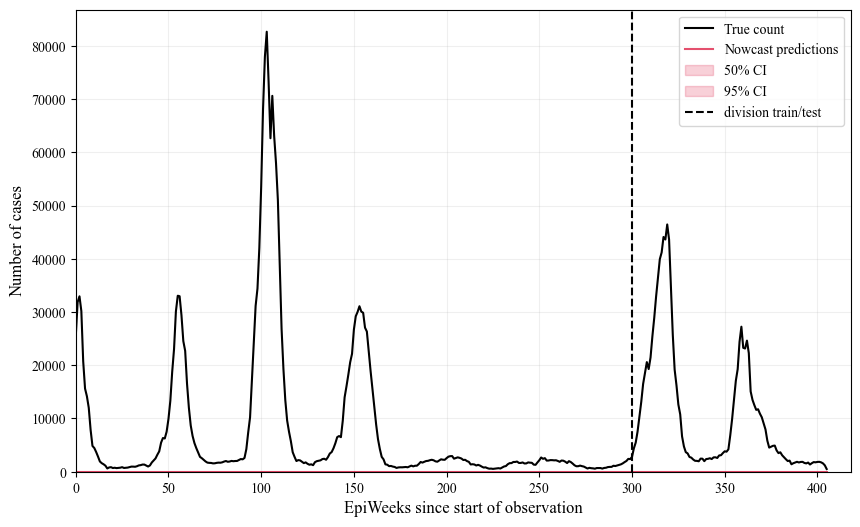

In [61]:
from forecastpnn.utils.plotting import plot_entire_confints

set_seeds(RANDOM_SEED) # biggest outbreak 600, 900
plot_entire_confints(dl, nowcast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, test_idcs=test_idcs, total = False, xlims=[0, 418])


In [34]:
from forecastpnn.utils.metrics import pnn_PIs_indiv, evaluate_PIs
set_seeds(RANDOM_SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn = pnn_PIs_indiv(nowcast_pnn, test_loader, random_split = RANDOM_SPLIT, save=False, future_obs=0) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn, test_loader, return_coverages=False, return_is_decomposed=False, total = False)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed